<a href="https://colab.research.google.com/github/Sara-Aziz074/01_simple_nodes__Edges__Graph/blob/main/student_study_schedule_Agentin_chatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [51]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [52]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

In [53]:
from langchain_google_genai import ChatGoogleGenerativeAI

def greet_user() -> str:
    """
    Provides a greeting message for creating a study schedule.

    Returns:
        str: A greeting message.
    """
    return "Hello! Ready to create your study schedule? Let's plan for success and achieve your goals together!"


from typing import List

from datetime import time, date, datetime

def create_study_schedule(subject_names: List[str], subject_std_hrs: List[str], start_dates: List[date]) -> dict:
    """
    Create a study schedule.

    Args:
        subject_names: List of subject names (str).
        subject_std_hrs: List of study hours for each subject (str format).
        start_dates: List of start dates for each subject (date format).

    Returns:
        dict: A dictionary representing the study schedule.
    """
    study_schedule = []
    for i in range(len(subject_names)):
        # Parse time string to datetime.time object
        time_obj = datetime.strptime(subject_std_hrs[i], "%H:%M:%S").time()
        study_schedule.append({
            "subject_name": subject_names[i],
            "subject_std_hrs": time_obj,
            "start_date": start_dates[i]
        })
    return {"schedule": study_schedule}



import random

def motivate_user() -> str:
    """
    Provides a random motivational message for the user.

    Returns:
        str: A motivational message.
    """
    quotes = [
        "Believe you can, and you're halfway there.",
        "Success is not final, failure is not fatal: It is the courage to continue that counts.",
        "Hardships often prepare ordinary people for an extraordinary destiny.",
        "Don't watch the clock; do what it does. Keep going.",
        "The future depends on what you do today.",
        "It does not matter how slowly you go as long as you do not stop.",
        "Your limitation—it’s only your imagination.",
        "Push yourself, because no one else is going to do it for you.",
        "Sometimes later becomes never. Do it now.",
        "Dream it. Wish it. Do it."
    ]
    return random.choice(quotes)



tools = [greet_user, create_study_schedule, motivate_user]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm_with_tools = llm.bind_tools(tools)

print(greet_user())
print(create_study_schedule)

print(motivate_user())



Hello! Ready to create your study schedule? Let's plan for success and achieve your goals together!
<function create_study_schedule at 0x7cd8d42832e0>
Success is not final, failure is not fatal: It is the courage to continue that counts.


In [54]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with only create a study schedule.")

# Node
def assistant(state: MessagesState) -> MessagesState:

   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

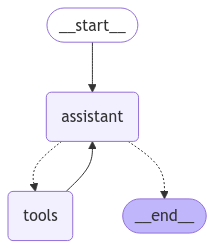

In [55]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
#messages = [HumanMessage(content="create my schedule my subject are python 02:00:00 star date 2025-01-28- end date 2025-02-20, sql 01:00:00 star date 2025-01-29- end date 2025-02-10, langgraph 01:10:00 star date 2025-01-28- end date 2025-02-20.")]

In [56]:
messages = [HumanMessage(content="create my schedule my subject are python 02:00:00 star date 2025-01-28- end date 2025-02-20, sql 01:00:00 star date 2025-01-29- end date 2025-02-10, langgraph 01:10:00 star date 2025-01-28- end date 2025-02-20.")]

messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

create my schedule my subject are python 02:00:00 star date 2025-01-28- end date 2025-02-20, sql 01:00:00 star date 2025-01-29- end date 2025-02-10, langgraph 01:10:00 star date 2025-01-28- end date 2025-02-20.
================================== Ai Message ==================================
Tool Calls:
  create_study_schedule (182c03c0-c084-4166-be62-2a4a665620ab)
 Call ID: 182c03c0-c084-4166-be62-2a4a665620ab
  Args:
    subject_names: ['python', 'sql', 'langgraph']
    start_dates: ['2025-01-28', '2025-01-29', '2025-01-28']
    subject_std_hrs: ['02:00:00', '01:00:00', '01:10:00']
================================= Tool Message =================================
Name: create_study_schedule

{'schedule': [{'subject_name': 'python', 'subject_std_hrs': datetime.time(2, 0), 'start_date': datetime.date(2025, 1, 28)}, {'subject_name': 'sql', 'subject_std_hrs': datetime.time(1, 0), 'start_date': datetime.date(20

# **save memory**

In [57]:
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

In [58]:
# Specify a thread
config1 = {"configurable": {"thread_id": "1"}}


In [59]:


# Specify an input
messages = [HumanMessage(content="create my schedule my subject are python 02:00:00 star date 2025-01-28- end date 2025-02-20, sql 01:00:00 star date 2025-01-29- end date 2025-02-10, langgraph 01:10:00 star date 2025-01-28- end date 2025-02-20.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

create my schedule my subject are python 02:00:00 star date 2025-01-28- end date 2025-02-20, sql 01:00:00 star date 2025-01-29- end date 2025-02-10, langgraph 01:10:00 star date 2025-01-28- end date 2025-02-20.
================================== Ai Message ==================================
Tool Calls:
  create_study_schedule (a4b419ec-60e5-4af8-9c98-7d7dd035b368)
 Call ID: a4b419ec-60e5-4af8-9c98-7d7dd035b368
  Args:
    subject_names: ['python', 'sql', 'langgraph']
    start_dates: ['2025-01-28', '2025-01-29', '2025-01-28']
    subject_std_hrs: ['02:00:00', '01:00:00', '01:10:00']
================================= Tool Message =================================
Name: create_study_schedule

{'schedule': [{'subject_name': 'python', 'subject_std_hrs': datetime.time(2, 0), 'start_date': datetime.date(2025, 1, 28)}, {'subject_name': 'sql', 'subject_std_hrs': datetime.time(1, 0), 'start_date': datetime.date(20

In [60]:
messages = [HumanMessage(content="Add that schdule  english 00:30:00 star date 2025-01-28- end date 2025-02-20 .")]

messages = react_graph_memory.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

create my schedule my subject are python 02:00:00 star date 2025-01-28- end date 2025-02-20, sql 01:00:00 star date 2025-01-29- end date 2025-02-10, langgraph 01:10:00 star date 2025-01-28- end date 2025-02-20.
================================== Ai Message ==================================
Tool Calls:
  create_study_schedule (a4b419ec-60e5-4af8-9c98-7d7dd035b368)
 Call ID: a4b419ec-60e5-4af8-9c98-7d7dd035b368
  Args:
    subject_names: ['python', 'sql', 'langgraph']
    start_dates: ['2025-01-28', '2025-01-29', '2025-01-28']
    subject_std_hrs: ['02:00:00', '01:00:00', '01:10:00']
================================= Tool Message =================================
Name: create_study_schedule

{'schedule': [{'subject_name': 'python', 'subject_std_hrs': datetime.time(2, 0), 'start_date': datetime.date(2025, 1, 28)}, {'subject_name': 'sql', 'subject_std_hrs': datetime.time(1, 0), 'start_date': datetime.date(20